## Topology-score detector pipeline (visual walkthrough)

Goal: reproduce the repository’s detector pipeline end-to-end on a tiny, low-dimensional example and visualize each step:

1. **Input** →
2. **Embedding** (2D/3D penultimate features) →
3. **Local kNN neighborhood** (from training embeddings) →
4. **Filtration** (Vietoris–Rips on the local point cloud) →
5. **Persistence diagrams** →
6. **Topology feature vector** (summary stats) →
7. **Detector score + threshold** (Mahalanobis + clean quantile)

This notebook reuses the repo’s implementations:
- `src.graph_scoring.compute_graph_scores_with_diagrams`
- `src.detectors.train_graph_detector` / `TopologyScoreDetector`

Run this notebook from the repo root with the project venv activated (`source venv/bin/activate`).


In [1]:
import os
import sys
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt

# Ensure imports work whether you run from repo root or from notebooks/.
# (In notebooks, __file__ is not defined, so we search upwards from CWD.)
def find_repo_root(start: Path) -> Path:
    start = Path(start).resolve()
    for p in [start, *start.parents]:
        if (p / "src").is_dir():
            return p
    return start

REPO_ROOT = find_repo_root(Path.cwd())
if str(REPO_ROOT) not in sys.path:
    sys.path.insert(0, str(REPO_ROOT))

import torch
from sklearn.neighbors import NearestNeighbors

from src.data import generate_two_moons, create_data_loaders
from src.models import TwoMoonsMLP, train_model, extract_features_batch
from src.utils import GraphConfig, DetectorConfig, AttackConfig, ModelConfig
from src.graph_scoring import compute_graph_scores, compute_graph_scores_with_diagrams
from src.adv_attacks import generate_adversarial_examples
from src.detectors import train_graph_detector

DEVICE = "cpu"
SEED = 0
np.random.seed(SEED)
torch.manual_seed(SEED)

plt.rcParams["figure.figsize"] = (7, 5)
plt.rcParams["axes.grid"] = True
print("repo root:", REPO_ROOT)
print("device:", DEVICE)


repo root: /Users/svenhockers/Desktop/project/topology-and-robustness-in-DNNs
device: cpu


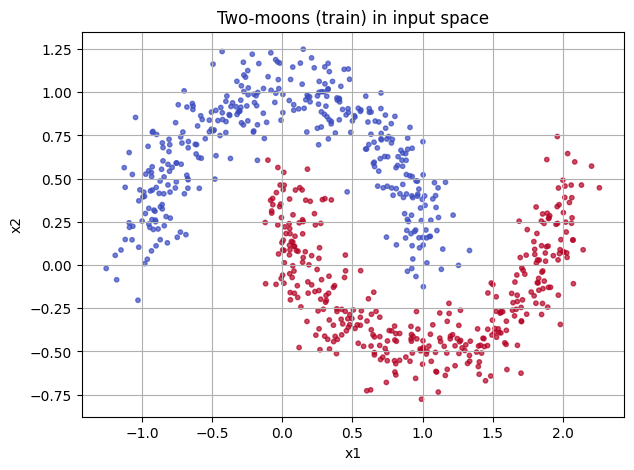

Epoch [10/200] Train Loss: 0.3098, Train Acc: 88.61%, Val Loss: 0.2885, Val Acc: 90.83%
Epoch [20/200] Train Loss: 0.1159, Train Acc: 98.33%, Val Loss: 0.0953, Val Acc: 98.75%
Epoch [30/200] Train Loss: 0.0332, Train Acc: 99.86%, Val Loss: 0.0284, Val Acc: 100.00%
Epoch [40/200] Train Loss: 0.0191, Train Acc: 100.00%, Val Loss: 0.0177, Val Acc: 100.00%
Epoch [50/200] Train Loss: 0.0158, Train Acc: 100.00%, Val Loss: 0.0151, Val Acc: 100.00%
Epoch [60/200] Train Loss: 0.0100, Train Acc: 100.00%, Val Loss: 0.0092, Val Acc: 100.00%
Epoch [70/200] Train Loss: 0.0077, Train Acc: 100.00%, Val Loss: 0.0084, Val Acc: 100.00%
Epoch [80/200] Train Loss: 0.0079, Train Acc: 99.86%, Val Loss: 0.0063, Val Acc: 100.00%
Epoch [90/200] Train Loss: 0.0122, Train Acc: 99.72%, Val Loss: 0.0062, Val Acc: 100.00%
Epoch [100/200] Train Loss: 0.0052, Train Acc: 100.00%, Val Loss: 0.0050, Val Acc: 100.00%
Epoch [110/200] Train Loss: 0.0046, Train Acc: 100.00%, Val Loss: 0.0048, Val Acc: 100.00%
Epoch [120/200]

In [2]:
# --- 1) Data: two moons in input space ---
X_train, y_train, X_val, y_val, X_test, y_test = generate_two_moons(
    n_samples=1200,
    noise=0.12,
    random_state=SEED,
)

fig, ax = plt.subplots()
ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=10, cmap="coolwarm", alpha=0.7)
ax.set_title("Two-moons (train) in input space")
ax.set_xlabel("x1")
ax.set_ylabel("x2")
plt.show()

# --- 2) Train a small MLP with a 3D penultimate embedding ---
# Important: the *last hidden dim* becomes the penultimate feature dimension.
#
# Use tanh to avoid "dead" ReLUs collapsing embeddings to ~0 (which makes PH trivial).
model = TwoMoonsMLP(input_dim=2, hidden_dims=[64, 32, 3], output_dim=2, activation="tanh")
train_loader, val_loader, test_loader = create_data_loaders(
    X_train, y_train, X_val, y_val, X_test, y_test, batch_size=128
)

train_hist = train_model(
    model,
    train_loader,
    val_loader,
    config=ModelConfig(epochs=200, learning_rate=5e-3, weight_decay=1e-4, batch_size=128),
    device=DEVICE,
)
model.eval()

print("final train acc:", train_hist["train_acc"][-1], "final val acc:", train_hist["val_acc"][-1])

# Build reference embeddings (train set) in feature space.
Z_train = extract_features_batch(model, X_train, layer="penultimate", device=DEVICE)
Z_test = extract_features_batch(model, X_test, layer="penultimate", device=DEVICE)

print("Z_train shape:", Z_train.shape)
print("Z_test shape:", Z_test.shape)
print("Z_train per-dim std:", np.std(Z_train, axis=0))

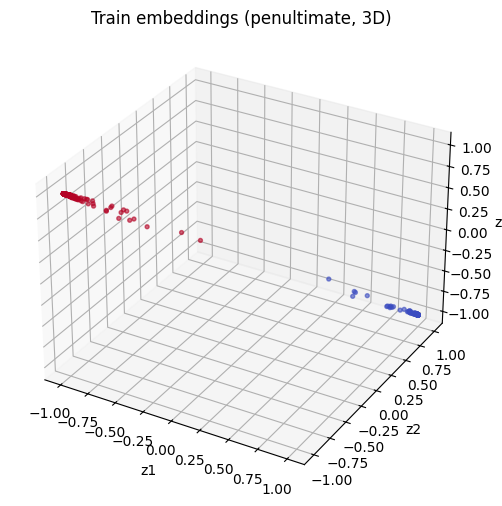

query index: 0 label: 1
x_q: [ 1.73712433 -0.29356918]
z_q: [-0.9931001  -0.99111646  0.9930881 ]


In [3]:
# --- 3) Visualize embedding space (3D) ---
# We'll visualize the 3D embedding with a simple 3D scatter.

from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

fig = plt.figure(figsize=(7, 6))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(Z_train[:, 0], Z_train[:, 1], Z_train[:, 2], c=y_train, s=8, cmap="coolwarm", alpha=0.6)
ax.set_title("Train embeddings (penultimate, 3D)")
ax.set_xlabel("z1")
ax.set_ylabel("z2")
ax.set_zlabel("z3")
plt.show()

# Pick a query point from test
q_idx = 0
x_q = X_test[q_idx]
y_q = int(y_test[q_idx])
z_q = Z_test[q_idx]
print("query index:", q_idx, "label:", y_q)
print("x_q:", x_q)
print("z_q:", z_q)


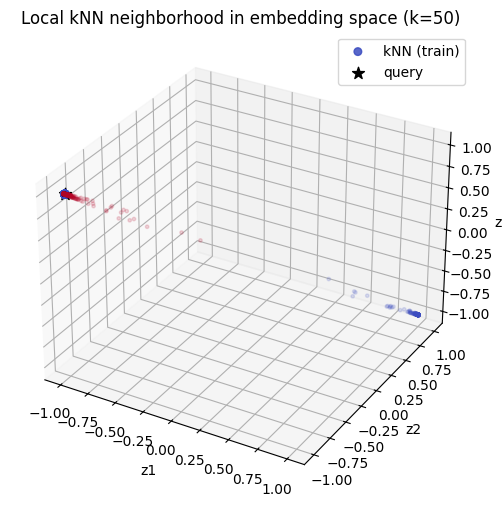

In [4]:
# --- 4) Localize: kNN neighborhood around the query in embedding space ---

topo_k = 50
nbrs = NearestNeighbors(n_neighbors=min(topo_k, len(Z_train)), metric="euclidean").fit(Z_train)
_, nn_idx = nbrs.kneighbors(z_q.reshape(1, -1))
nn_idx = nn_idx[0]
Z_nn = Z_train[nn_idx]
y_nn = y_train[nn_idx]

fig = plt.figure(figsize=(7, 6))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(Z_train[:, 0], Z_train[:, 1], Z_train[:, 2], c=y_train, s=6, cmap="coolwarm", alpha=0.15)
ax.scatter(Z_nn[:, 0], Z_nn[:, 1], Z_nn[:, 2], c=y_nn, s=30, cmap="coolwarm", alpha=0.85, label="kNN (train)")
ax.scatter([z_q[0]], [z_q[1]], [z_q[2]], c="black", s=80, marker="*", label="query")
ax.set_title(f"Local kNN neighborhood in embedding space (k={len(nn_idx)})")
ax.set_xlabel("z1")
ax.set_ylabel("z2")
ax.set_zlabel("z3")
ax.legend(loc="best")
plt.show()


local cloud shape: (51, 3) (includes query + neighbors)
topology feature keys: ['topo_h0_count', 'topo_h0_entropy', 'topo_h0_l2_persistence', 'topo_h0_max_persistence', 'topo_h0_total_persistence', 'topo_h1_count', 'topo_h1_entropy', 'topo_h1_l2_persistence', 'topo_h1_max_persistence', 'topo_h1_total_persistence']
pairwise distances (cloud): min/median/max = 2.4228023393991777e-05 0.0023674153925584813 0.006979878356585432
fraction of (near-)zero distances: 0.0
radius 0.0008369: edges in 1-skeleton = 128
radius 0.001426: edges in 1-skeleton = 255
radius 0.002041: edges in 1-skeleton = 446


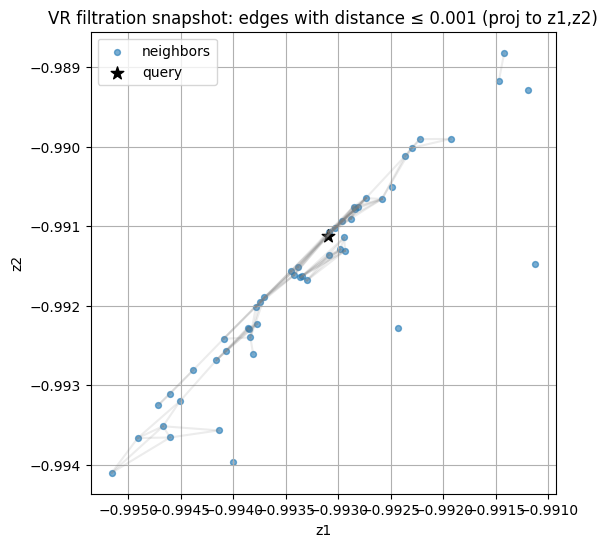

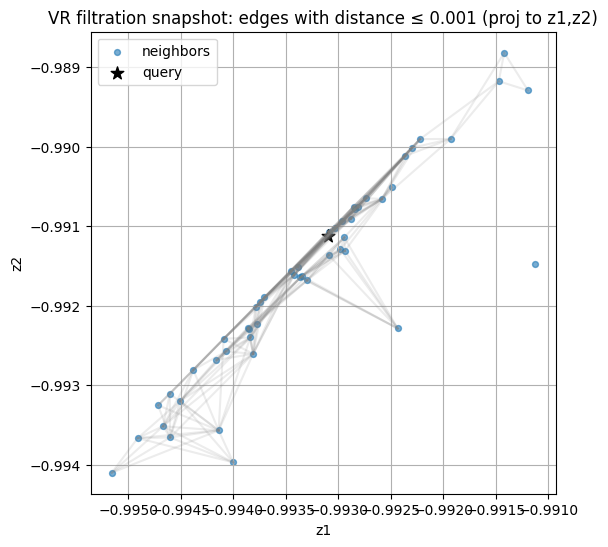

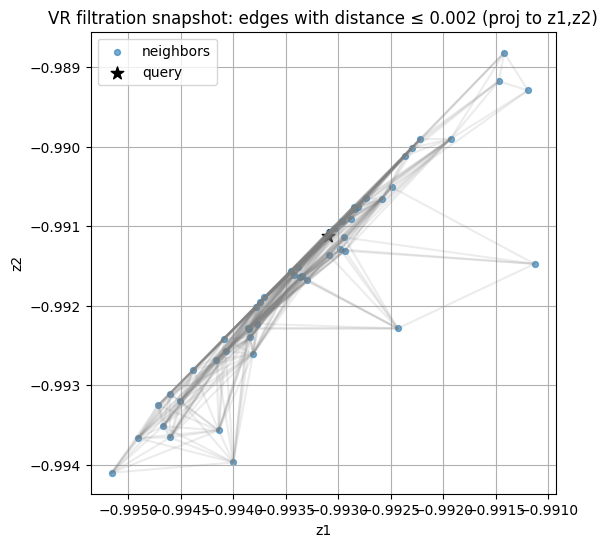

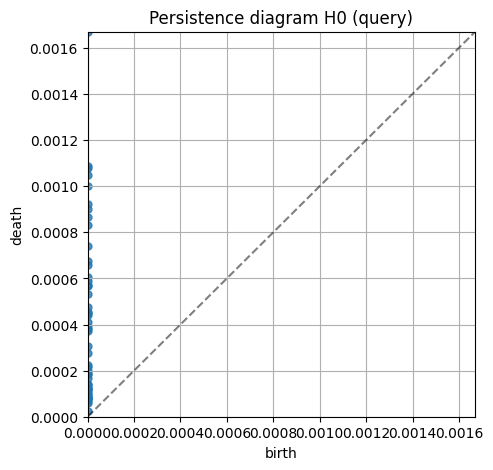

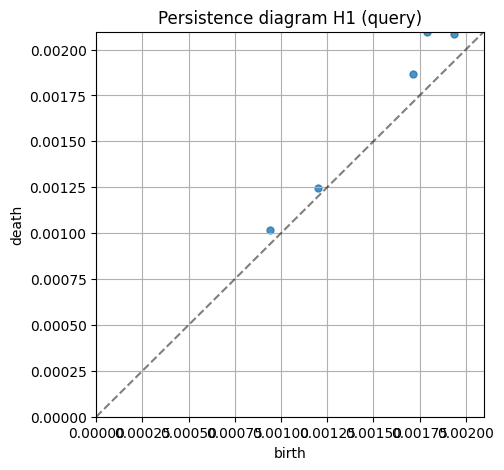

In [5]:
# --- 5) Topologize: build a filtration + compute persistence diagrams for the local point cloud ---

# We reuse the repo helper which internally constructs the same local cloud:
#   cloud = [z_query] ∪ kNN(Z_train)
# and runs PH via `local_persistence_features(..., return_diagrams=True)`.

graph_cfg = GraphConfig(
    use_topology=True,
    use_baseline_scores=False,
    space="feature",
    feature_layer="penultimate",
    topo_k=topo_k,
    topo_maxdim=1,
    topo_preprocess="none",
    topo_min_persistence=1e-6,
    topo_metric="euclidean",
    topo_thresh=None,
    topo_filtration="standard",
)

# f_train is unused for topology here, but is required by the signature.
f_train_dummy = np.zeros((len(X_train),), dtype=float)

features_q, diagrams_q, cloud_q = compute_graph_scores_with_diagrams(
    X_point=x_q,
    model=model,
    Z_train=Z_train,
    f_train=f_train_dummy,
    graph_params=graph_cfg,
    device=DEVICE,
)

cloud_q = np.asarray(cloud_q, dtype=float)
print("local cloud shape:", cloud_q.shape, "(includes query + neighbors)")
print("topology feature keys:", sorted(features_q.keys()))

# Plot a simple Vietoris–Rips filtration snapshot on the cloud in 2D (project to first 2 coords)
# (VR filtration is defined by pairwise distances; this is just a visualization aid.)

def pairwise_dist(X):
    X = np.asarray(X, dtype=float)
    s = np.sum(X * X, axis=1, keepdims=True)
    D2 = s + s.T - 2.0 * (X @ X.T)
    D2 = np.maximum(D2, 0.0)
    return np.sqrt(D2)

D = pairwise_dist(cloud_q)

# choose a few radii based on distance quantiles (exclude diagonal)
d_flat = D[np.triu_indices_from(D, k=1)]
print("pairwise distances (cloud): min/median/max =",
      float(np.min(d_flat)), float(np.median(d_flat)), float(np.max(d_flat)))
print("fraction of (near-)zero distances:", float(np.mean(d_flat <= 1e-12)))

# Use larger quantiles so the 1-skeleton is visible even when the cloud is tight.
qs = (0.10, 0.20, 0.35)
rs = [float(np.quantile(d_flat, q)) for q in qs]

# Print edge counts at each radius to confirm the visualization isn't empty.
for r in rs:
    n_edges = int(np.sum(np.triu(D <= r, k=1)))
    print(f"radius {r:.4g}: edges in 1-skeleton = {n_edges}")

X2 = cloud_q[:, :2]
for r in rs:
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.scatter(X2[1:, 0], X2[1:, 1], s=18, alpha=0.6, label="neighbors")
    ax.scatter([X2[0, 0]], [X2[0, 1]], c="black", s=90, marker="*", label="query")
    # edges at radius r
    n = X2.shape[0]
    for i in range(n):
        for j in range(i + 1, n):
            if D[i, j] <= r:
                ax.plot([X2[i, 0], X2[j, 0]], [X2[i, 1], X2[j, 1]], color="gray", alpha=0.15)
    ax.set_title(f"VR filtration snapshot: edges with distance ≤ {r:.3f} (proj to z1,z2)")
    ax.set_xlabel("z1")
    ax.set_ylabel("z2")
    ax.legend(loc="best")
    plt.show()

# Plot persistence diagrams (H0, H1)

def plot_pd(diag, title):
    diag = np.asarray(diag, dtype=float)
    fig, ax = plt.subplots(figsize=(5, 5))

    if diag.size:
        # Many PH backends encode essential features with death=inf.
        finite_mask = np.isfinite(diag[:, 1])
        finite = diag[finite_mask]
        if finite.size:
            ax.scatter(finite[:, 0], finite[:, 1], s=25, alpha=0.8)

        # Choose axis limits from finite entries only (avoid lim=inf making plot look empty).
        finite_vals = diag[np.isfinite(diag)]
        lim = float(np.max(finite_vals)) if finite_vals.size else 1.0
    else:
        lim = 1.0

    lim = max(lim, 1e-3)
    ax.plot([0, lim], [0, lim], "k--", alpha=0.5)
    ax.set_xlim(0, lim)
    ax.set_ylim(0, lim)
    ax.set_title(title)
    ax.set_xlabel("birth")
    ax.set_ylabel("death")
    plt.show()

plot_pd(diagrams_q[0], "Persistence diagram H0 (query)")
if len(diagrams_q) > 1:
    plot_pd(diagrams_q[1], "Persistence diagram H1 (query)")


In [6]:
# --- 6) Vectorize: show the topology feature vector v(x) for the query ---

# This dict is exactly what the detector consumes as a feature vector.
# We'll print it in a stable order.
for k in sorted(features_q.keys()):
    print(f"{k:28s} = {features_q[k]:.6g}")


topo_h0_count                = 50
topo_h0_entropy              = 3.56991
topo_h0_l2_persistence       = 0.00393042
topo_h0_max_persistence      = 0.00166998
topo_h0_total_persistence    = 0.0211192
topo_h1_count                = 5
topo_h1_entropy              = 1.4139
topo_h1_l2_persistence       = 0.000382551
topo_h1_max_persistence      = 0.000307611
topo_h1_total_persistence    = 0.000721737


detector threshold: 3.4389151355651437
clean query score: 31.64479033160937 flag: 1
adv query score: 32.15309495507847 flag: 1
||z_adv - z_clean||: 0.4250915050506592


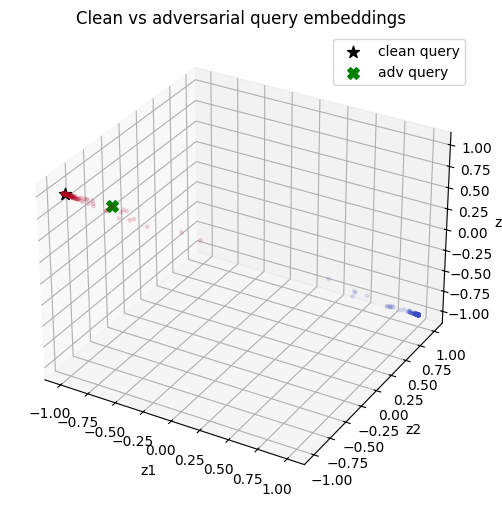

In [7]:
# --- 7) Score: fit the TopologyScoreDetector on clean data, score clean vs adversarial ---

# Compute topology features for a small clean calibration set.
# Note: this calls PH once per point, so keep it small for a notebook demo.

n_cal = 120
X_cal = X_train[:n_cal]

scores_cal = compute_graph_scores(
    X_points=np.asarray(X_cal),
    model=model,
    Z_train=np.asarray(Z_train),
    f_train=np.asarray(f_train_dummy),
    graph_params=graph_cfg,
    device=DEVICE,
)

# DetectorConfig controls which topo keys become the feature vector (default selection is fine).
det_cfg = DetectorConfig(
    detector_type="topology_score",
    topo_feature_keys=None,
    topo_cov_shrinkage=1e-3,
    topo_percentile=95.0,
)

labels_clean = np.zeros((len(X_cal),), dtype=int)

det = train_graph_detector(scores_cal, labels_clean, det_cfg)
print("detector threshold:", det.threshold)

# Score the clean query
scores_q = compute_graph_scores(
    X_points=np.asarray([x_q]),
    model=model,
    Z_train=np.asarray(Z_train),
    f_train=np.asarray(f_train_dummy),
    graph_params=graph_cfg,
    device=DEVICE,
)
score_clean_q = float(det.score(scores_q)[0])
print("clean query score:", score_clean_q, "flag:", int(score_clean_q > det.threshold))

# Make an adversarial version of the same query and score it.
attack_cfg = AttackConfig(
    attack_type="pgd",
    epsilon=0.25,
    num_steps=40,
    step_size=0.02,
    random_start=True,
)

x_adv = generate_adversarial_examples(model, X=np.asarray([x_q]), y=np.asarray([y_q]), config=attack_cfg, device=DEVICE, batch_size=1)[0]

scores_adv_q = compute_graph_scores(
    X_points=np.asarray([x_adv]),
    model=model,
    Z_train=np.asarray(Z_train),
    f_train=np.asarray(f_train_dummy),
    graph_params=graph_cfg,
    device=DEVICE,
)
score_adv_q = float(det.score(scores_adv_q)[0])
print("adv query score:", score_adv_q, "flag:", int(score_adv_q > det.threshold))

# Compare the two local neighborhoods in embedding space
z_adv = extract_features_batch(model, np.asarray([x_adv]), layer="penultimate", device=DEVICE)[0]
print("||z_adv - z_clean||:", float(np.linalg.norm(z_adv - z_q)))

fig = plt.figure(figsize=(7, 6))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(Z_train[:, 0], Z_train[:, 1], Z_train[:, 2], c=y_train, s=6, cmap="coolwarm", alpha=0.12)
ax.scatter([z_q[0]], [z_q[1]], [z_q[2]], c="black", s=80, marker="*", label="clean query")
ax.scatter([z_adv[0]], [z_adv[1]], [z_adv[2]], c="green", s=70, marker="X", label="adv query")
ax.set_title("Clean vs adversarial query embeddings")
ax.set_xlabel("z1")
ax.set_ylabel("z2")
ax.set_zlabel("z3")
ax.legend(loc="best")
plt.show()


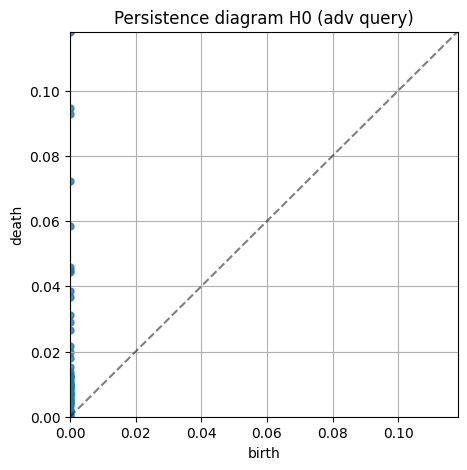

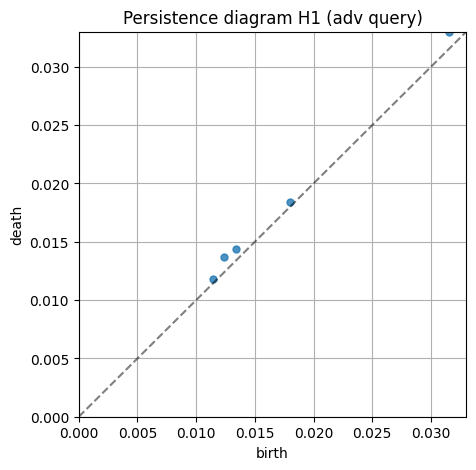

Feature deltas (adv - clean):
topo_h0_count                +0
topo_h0_entropy              -0.212199
topo_h0_l2_persistence       +0.231148
topo_h0_max_persistence      +0.116433
topo_h0_total_persistence    +1.02843
topo_h1_count                +0
topo_h1_entropy              +0.0832837
topo_h1_l2_persistence       +0.00185336
topo_h1_max_persistence      +0.00113434
topo_h1_total_persistence    +0.00381902


In [8]:
# --- 8) (Optional) Compare diagrams clean vs adversarial for the same query ---

features_adv, diagrams_adv, cloud_adv = compute_graph_scores_with_diagrams(
    X_point=x_adv,
    model=model,
    Z_train=Z_train,
    f_train=f_train_dummy,
    graph_params=graph_cfg,
    device=DEVICE,
)

plot_pd(diagrams_adv[0], "Persistence diagram H0 (adv query)")
if len(diagrams_adv) > 1:
    plot_pd(diagrams_adv[1], "Persistence diagram H1 (adv query)")

print("Feature deltas (adv - clean):")
for k in sorted(features_q.keys()):
    print(f"{k:28s} {features_adv.get(k,0.0) - features_q.get(k,0.0):+.6g}")
